## AlexNet Training on FER2013 (Kaggle GPU)

In [3]:
!pip install -q kagglehub

In [4]:
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [1]:
import os
from collections import Counter
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

WORK_DIR = Path('/kaggle/working')
CANDIDATE_ROOTS = [
    Path(path) if 'path' in globals() else None,
    Path('/kaggle/input/fer2013'),
    Path('/kaggle/input/msambare-fer2013'),
    WORK_DIR / 'fer2013'
]
DATA_ROOT = None
for candidate in CANDIDATE_ROOTS:
    if candidate and candidate.exists():
        DATA_ROOT = candidate
        break
if DATA_ROOT is None:
    raise FileNotFoundError('Dataset folder not found. Set DATA_ROOT manually.')

def pick_dir(options):
    for name in options:
        d = DATA_ROOT / name
        if d.exists():
            return d
    raise FileNotFoundError(f'Missing directories {options} under {DATA_ROOT}')

TRAIN_DIR = pick_dir(['train', 'Train', 'training', 'Training'])
VAL_DIR = pick_dir(['val', 'validation', 'Validation', 'test', 'Test', 'PublicTest', 'PrivateTest'])

IMAGE_SIZE = (227, 227)
BATCH_SIZE = 64
EPOCHS = 40
AUTOTUNE = tf.data.AUTOTUNE
MODEL_PATH = WORK_DIR / 'alexnet_fer2013.keras'

print('Using data from', DATA_ROOT)
print('Train dir:', TRAIN_DIR)
print('Val/Test dir:', VAL_DIR)


2025-11-12 14:27:29.368190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762957649.885133      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762957650.003961      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using data from /kaggle/input/fer2013
Train dir: /kaggle/input/fer2013/train
Val/Test dir: /kaggle/input/fer2013/test


In [2]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=True,
)
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

CLASS_NAMES = raw_train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

def preprocess(ds, augment=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (augment_layer(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

augment_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
], name='augment')

train_ds = preprocess(raw_train_ds, augment=True)
val_ds = preprocess(raw_val_ds, augment=False)

counts = Counter()
for class_name in CLASS_NAMES:
    class_dir = TRAIN_DIR / class_name
    counts[class_name] = len(list(class_dir.glob('**/*.*')))
class_weights = {idx: (sum(counts.values()) / (NUM_CLASSES * counts[name])) for idx, name in enumerate(CLASS_NAMES) if counts[name] > 0}

print('Classes:', CLASS_NAMES)
print('Class weights:', class_weights)


Found 28709 files belonging to 7 classes.


I0000 00:00:1762957704.990659      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762957704.991402      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 7178 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class weights: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [3]:
def build_model(input_shape=(227, 227, 3), num_classes=NUM_CLASSES):
    reg = tf.keras.regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(96, 11, strides=4, padding='same', kernel_initializer='he_normal', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(3, strides=2),
        layers.Dropout(0.1),

        layers.Conv2D(256, 5, padding='same', kernel_initializer='he_normal', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(3, strides=2),
        layers.Dropout(0.15),

        layers.Conv2D(384, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(384, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(3, strides=2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=reg),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 57, 57, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 57, 57, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,58

 Total params: 3,889,927 (14.84 MB)

 Trainable params: 3,886,151 (14.82 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [4]:
checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early = EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True, verbose=1)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=3e-5, verbose=1)
callbacks = [checkpoint, early, reduce]

optimizer = None
if hasattr(tf.keras.optimizers, 'AdamW'):
    try:
        optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4, global_clipnorm=1.0)
        print('Using AdamW optimizer')
    except Exception as err:
        print('AdamW failed:', err)
        optimizer = None
if optimizer is None and hasattr(tf.keras.optimizers, 'legacy') and hasattr(tf.keras.optimizers.legacy, 'AdamW'):
    try:
        optimizer = tf.keras.optimizers.legacy.AdamW(learning_rate=1e-3, weight_decay=1e-4)
        print('Using legacy AdamW optimizer')
    except Exception as err:
        print('Legacy AdamW failed:', err)
        optimizer = None
if optimizer is None:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
    print('Using fallback Adam optimizer')

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

history = model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1,
)


Using AdamW optimizer
Epoch 1/40


I0000 00:00:1762957779.379096     117 service.cc:148] XLA service 0x7e69c400e790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762957779.380911     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762957779.380935     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762957780.632882     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/449 ━━━━━━━━━━━━━━━━━━━━ 2:37:54 21s/step - accuracy: 0.1250 - loss: 3.6893

I0000 00:00:1762957794.375815     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.1668 - loss: 2.7546
Epoch 1: val_accuracy improved from -inf to 0.14294, saving model to /kaggle/working/alexnet_fer2013.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 224s 452ms/step - accuracy: 0.1668 - loss: 2.7543 - val_accuracy: 0.1429 - val_loss: 2.8318 - learning_rate: 0.0010
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.1738 - loss: 2.2955
Epoch 2: val_accuracy improved from 0.14294 to 0.17177, saving model to /kaggle/working/alexnet_fer2013.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 341ms/step - accuracy: 0.1738 - loss: 2.2955 - val_accuracy: 0.1718 - val_loss: 2.1344 - learning_rate: 0.0010
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.2126 - loss: 2.1080
Epoch 3: val_accuracy improved from 0.17177 to 0.18501, saving model to /kaggle/working/alexnet_fer2013.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 157s 348ms/step - accuracy: 0.2126 - loss: 2.1080 - val_accuracy: 0.1850 - val_loss: 2.1795 - learnin

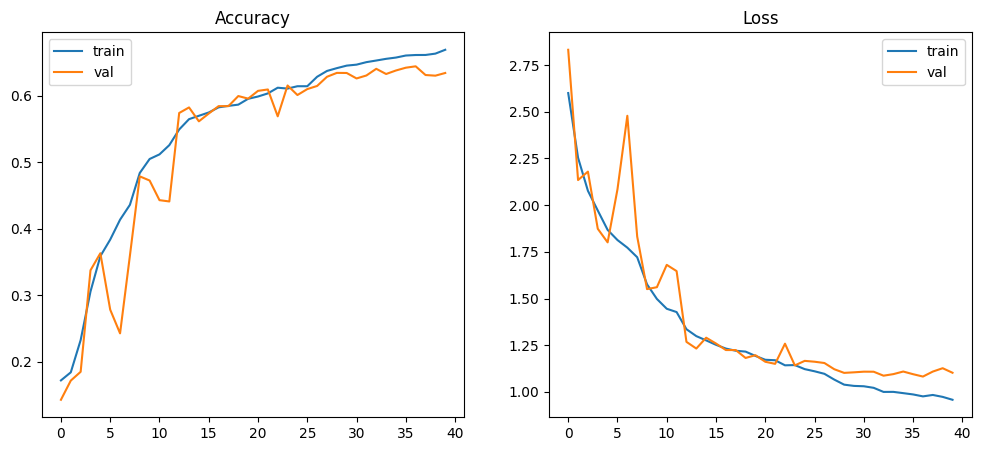

Best model stored at /kaggle/working/alexnet_fer2013.keras


In [5]:
metrics_history = model.history.history if hasattr(model, 'history') else {}
if metrics_history:
    acc = metrics_history.get('accuracy', [])
    val_acc = metrics_history.get('val_accuracy', [])
    loss = metrics_history.get('loss', [])
    val_loss = metrics_history.get('val_loss', [])

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label='train')
    plt.plot(val_acc, label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='val')
    plt.title('Loss')
    plt.legend()
    plt.show()

print('Best model stored at', MODEL_PATH)
